# Classification of Breast Cancer Histopathological Images Using Machine Learning

## Preparing Data

### Importing Libraries

In [ ]:
#core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

#tensorflow & keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2, VGG19, ResNet50, InceptionV3, EfficientNetB0, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D,GlobalMaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Layer
#from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,f1_score,recall_score,precision_score, ConfusionMatrixDisplay

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
seed = 42
np.random.seed =seed

### Loading Data

In [ ]:
image_path = '/kaggle/input/breakhis-40x/Multiclass_40x/'
data = tf.keras.utils.image_dataset_from_directory(image_path)

Found 1995 files belonging to 8 classes.


In [ ]:
data_dir_list = os.listdir(image_path)
print(data_dir_list)

['M_P', 'B_F', 'M_M', 'B_T', 'M_D', 'B_A', 'M_L', 'B_P']


### Creating path to save models

In [ ]:
if not os.path.isdir('/kaggle/working/models/'):
  os.makedirs('/kaggle/working/models/')
else:
  print('Exists')

In [ ]:
if not os.path.isdir('/kaggle/working/checkpoints/'):
    os.makedirs('/kaggle/working/checkpoints/')
else:
  print('Exists')

checkpoint_path = '/kaggle/working/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

### Labelling Data

In [ ]:
labels = ['B_A','B_F','B_P','B_T','M_D','M_L','M_M','M_P']

# to load image  linked with labels from dirictory
def load_images_from_directory(main_dirictory):
    total_labels=[]
    images =[]
    pathes =[]
    B_A=0
    B_F=0
    B_P=0
    B_T=0
    M_D=0
    M_L=0
    M_M=0
    M_P=0

    for lab in labels:
      full_path = os.path.join(image_path,lab)
      for image in os.listdir(full_path):
        img = cv2.imread(full_path+'/'+image)
        img = cv2.resize(img,(64,64))
        images.append(img)
        pathes.append(full_path+'/'+image)
        if lab  == 'B_A':
          label = 0
          B_A+= 1
        elif lab == 'B_F' :
          label = 1
          B_F+=1
        elif lab == 'B_P' :
          label = 2
          B_P+=1
        elif lab == 'B_T' :
          label = 3
          B_T+=1
        elif lab == 'M_D' :
          label = 4
          M_D+=1
        elif lab == 'M_L' :
          label = 5
          M_L+=1
        elif lab == 'M_M' :
          label = 6
          M_M+=1
        elif lab == 'M_P' :
          label = 7
          M_P+=1
        total_labels.append(label)

    print('No. of B_A images = ',B_A)
    print('No. of B_F images = ',B_F)
    print('No. of B_P images = ',B_P)
    print('No. of B_T images = ',B_T)
    print('No. of M_D images = ',M_D)
    print('No. of M_L images = ',M_L)
    print('No. of M_M images = ',M_M)
    print('No. of M_P images = ',M_P)
    return shuffle(images,total_labels,pathes,random_state=756349782)

# get label Name
def get_Label(number):
    labels = {0:'B_A',1:'B_F',2:'B_P',3:'B_T',4:'M_D',5:'M_L',6:'M_M',7:'M_P'}
    return labels[number]

In [ ]:
# Displaying umber of images in each class
images,all_labels,pathes =  load_images_from_directory(image_path)

No. of B_A images =  114
No. of B_F images =  253
No. of B_P images =  109
No. of B_T images =  149
No. of M_D images =  864
No. of M_L images =  156
No. of M_M images =  205
No. of M_P images =  145


In [ ]:
#creat data frame to save each image with its label
df =pd.DataFrame({
    'image_path':pathes,
    'label':all_labels,
})
df

,image_path,label
0,/kaggle/input/breakhis-40x/Multiclass_40x/B_T/...,3
1,/kaggle/input/breakhis-40x/Multiclass_40x/M_M/...,6
2,/kaggle/input/breakhis-40x/Multiclass_40x/M_D/...,4
3,/kaggle/input/breakhis-40x/Multiclass_40x/B_F/...,1
4,/kaggle/input/breakhis-40x/Multiclass_40x/M_D/...,4
...,...,...
1990,/kaggle/input/breakhis-40x/Multiclass_40x/B_A/...,0
1991,/kaggle/input/breakhis-40x/Multiclass_40x/B_F/...,1
1992,/kaggle/input/breakhis-40x/Multiclass_40x/M_D/...,4
1993,/kaggle/input/breakhis-40x/Multiclass_40x/B_A/...,0


In [ ]:
# Distribuion of images in each class
df['label'].value_counts(normalize=True).sort_index().mul(100).round(2).astype(str) + ' %'

label
0     5.71 %
1    12.68 %
2     5.46 %
3     7.47 %
4    43.31 %
5     7.82 %
6    10.28 %
7     7.27 %
Name: proportion, dtype: object

### Data Visualization

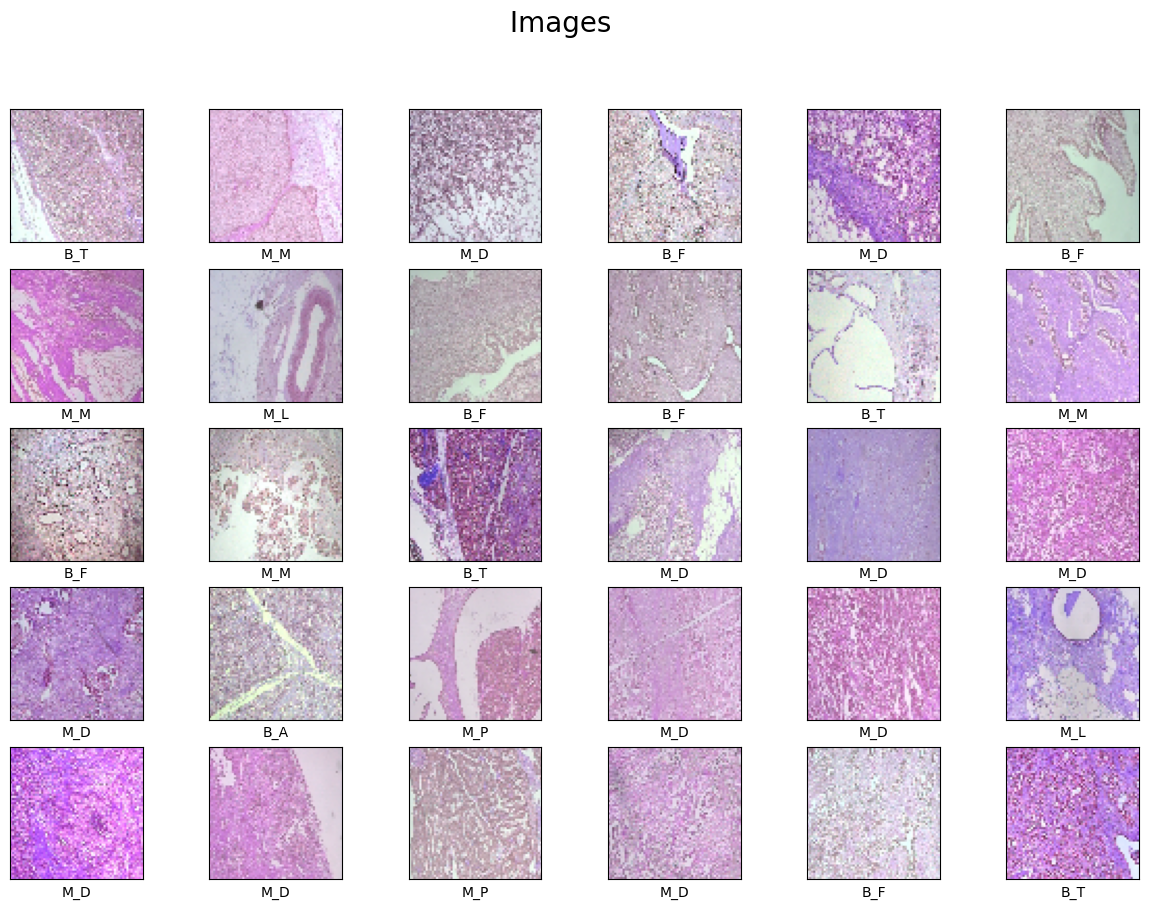

In [ ]:
# Displaying few random images
plt.figure(figsize=(15,10))
plt.suptitle(" Images", fontsize=20)
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(get_Label(all_labels[i]))
    plt.imshow(images[i], cmap=plt.cm.binary)

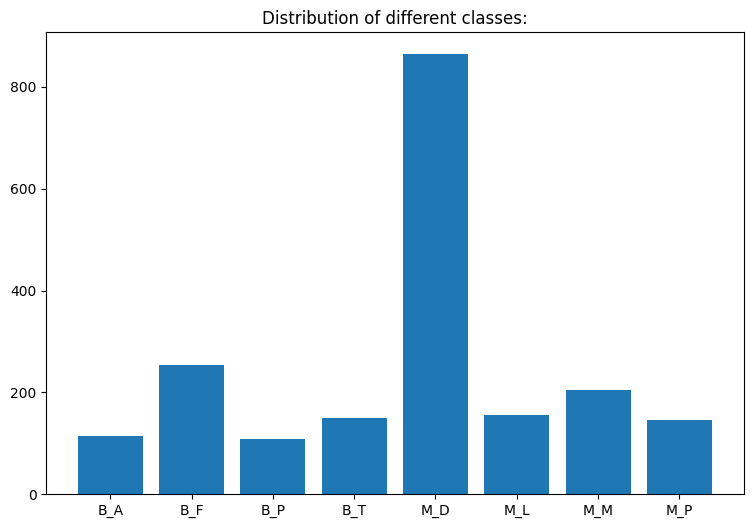

In [ ]:
image_folder = ['B_A','B_F', 'B_P', 'B_T', 'M_D', 'M_L', 'M_M', 'M_P']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir(image_path+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes:')
plt.show()

### Splitting Data

In [ ]:
x_train,x_test,y_train,y_test  = train_test_split(images,all_labels ,random_state=42,shuffle=True,test_size=0.2)
x_train = np.asarray(x_train,np.float32)/255
x_test  = np.asarray(x_test,np.float32)/255
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

### Processing Imbalanced Data

In [ ]:
x_train_imbalanced = x_train.copy()
x_test_imbalanced = x_test.copy()
y_train_imbalanced = to_categorical(y_train)
y_test_imbalanced = to_categorical(y_test)

In [ ]:
print('Imbalanced train images shape is   : ',x_train_imbalanced.shape)
print('Imbalanced train  labels  shape is : ',y_train_imbalanced.shape)
print('Imbalanced test images shape is   : ',x_test_imbalanced.shape)
print('Imbalanced test  labels  shape is : ',y_test_imbalanced.shape)

Imbalanced train images shape is   :  (1596, 64, 64, 3)
Imbalanced train  labels  shape is :  (1596, 8)
Imbalanced test images shape is   :  (399, 64, 64, 3)
Imbalanced test  labels  shape is :  (399, 8)


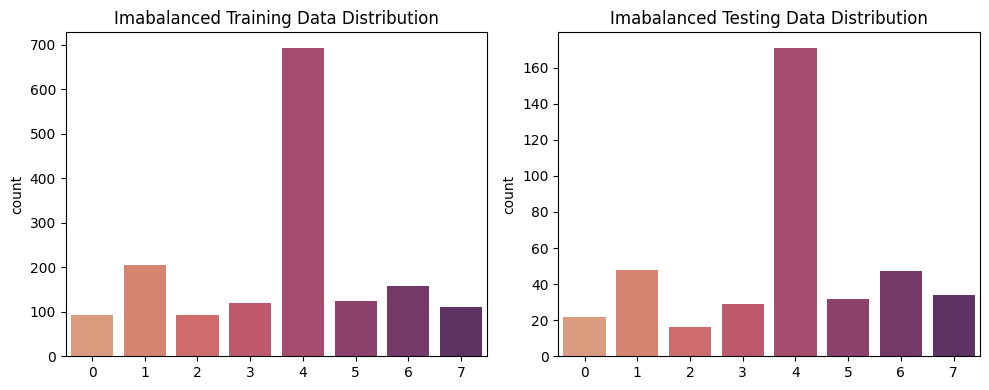

In [ ]:
plt.rcParams["figure.figsize"] = [10.00, 4.00]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1, 2)
sns.countplot(x=y_train,palette='flare', ax=axes[0]).set(title='Imabalanced Training Data Distribution')
sns.countplot(x=y_test,palette='flare', ax=axes[1]).set(title='Imabalanced Testing Data Distribution')
plt.show()

### Balancing Data

In [ ]:
shape = 64*64*3
x_train_shape = x_train.reshape(x_train.shape[0],shape )
x_test_shape  = x_test.reshape(x_test.shape[0], shape)
print('Shape of new train data is :',x_train_shape.shape)
print('Shape of new test data is :',x_test_shape.shape)

Shape of new train data is : (1596, 12288)
Shape of new test data is : (399, 12288)


In [ ]:
# balancing using smote and tomek link
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
x_train_fit, y_train_fit = smote_tomek.fit_resample(x_train_shape, y_train)
x_test_fit,  y_test_fit   = smote_tomek.fit_resample(x_test_shape, y_test)
# return data to its original shape
x_train_balanced = x_train_fit.reshape(x_train_fit.shape[0],64,64,3)
x_test_balanced  = x_test_fit.reshape(x_test_fit.shape[0], 64,64,3)
y_train_balanced = to_categorical(y_train_fit)
y_test_balanced = to_categorical(y_test_fit)

In [ ]:
print('Balanced train images shape is   : ',x_train_balanced.shape)
print('Balanced train  labels  shape is : ',y_train_balanced.shape)
print('Balanced test images shape is   : ',x_test_balanced.shape)
print('Balanced test  labels  shape is : ',y_test_balanced.shape)

Balanced train images shape is   :  (5544, 64, 64, 3)
Balanced train  labels  shape is :  (5544, 8)
Balanced test images shape is   :  (1368, 64, 64, 3)
Balanced test  labels  shape is :  (1368, 8)


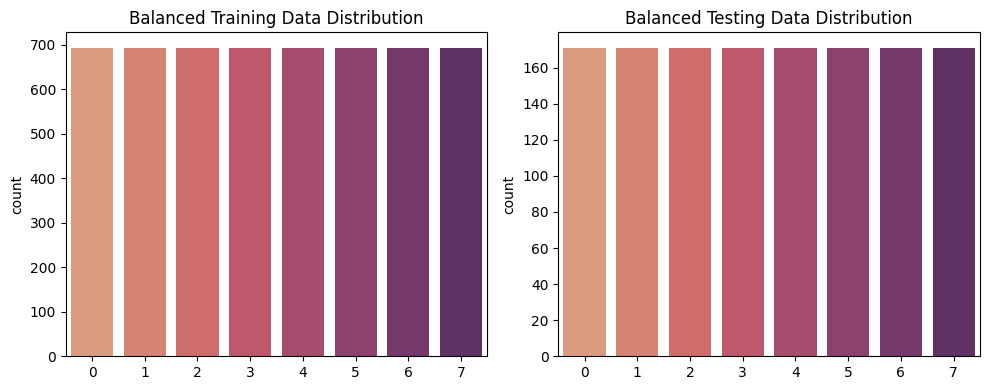

In [ ]:
plt.rcParams["figure.figsize"] = [10.00, 4.00]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1, 2)
sns.countplot(x=y_train_fit,palette='flare', ax=axes[0]).set(title='Balanced Training Data Distribution')
sns.countplot(x=y_test_fit,palette='flare', ax=axes[1]).set(title='Balanced Testing Data Distribution')
plt.show()

### Original Labels

In [ ]:
y_true_imbalanced = pd.DataFrame(y_test_imbalanced).idxmax(axis=1)
y_true_imbalanced

0      4
1      4
2      0
3      4
4      4
      ..
394    6
395    4
396    4
397    2
398    6
Length: 399, dtype: int64

In [ ]:
y_true_balanced = pd.DataFrame(y_test_balanced).idxmax(axis=1)
y_true_balanced

0       4
1       4
2       0
3       4
4       4
       ..
1363    7
1364    7
1365    7
1366    7
1367    7
Length: 1368, dtype: int64

## CNN

### Defining CNN

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.4))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(8, activation='softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_2 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                        

### Compiling CNN

In [ ]:
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Add callbacks
#early_stop = EarlyStopping(monitor='val_loss', patience=10,verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,save_freq=5,
                             )
callbacks_list = [cp_callback, learning_rate_reduction]

### Training CNN on Imbalanced Data

In [ ]:
#Fit model
cnn_imbalanced = cnn_model.fit(x_train_imbalanced,y_train_imbalanced, epochs=50,
                               validation_data = (x_test_imbalanced, y_test_imbalanced),
                               callbacks=callbacks_list
                              )

Epoch 1/50

50/50 [==============================] - 40s 749ms/step - loss: 2.0492 - accuracy: 0.3872 - val_loss: 110.6401 - val_accuracy: 0.0727 - lr: 0.0100

Epoch 2/50

50/50 [==============================] - 37s 744ms/step - loss: 1.5501 - accuracy: 0.4956 - val_loss: 2.9126 - val_accuracy: 0.1178 - lr: 0.0100

Epoch 3/50

50/50 [==============================] - 36s 727ms/step - loss: 1.3819 - accuracy: 0.5332 - val_loss: 2.0530 - val_accuracy: 0.1880 - lr: 0.0100

Epoch 4/50

50/50 [==============================] - 37s 732ms/step - loss: 1.2183 - accuracy: 0.5508 - val_loss: 1.9400 - val_accuracy: 0.4712 - lr: 0.0100

Epoch 5/50

50/50 [==============================] - 38s 757ms/step - loss: 1.1635 - accuracy: 0.5827 - val_loss: 3.1250 - val_accuracy: 0.3734 - lr: 0.0100

Epoch 6/50

50/50 [==============================] - 45s 893ms/step - loss: 1.1488 - accuracy: 0.5840 - val_loss: 1.6467 - val_accuracy: 0.4536 - lr: 0.0100

Epoch 7/50

50/50 [==============================]

In [ ]:
#Evaluate Model
train_loss_cnn_imbalanced, train_acc_cnn_imbalanced = cnn_model.evaluate(x_train_imbalanced,y_train_imbalanced)
test_loss_cnn_imbalanced, test_acc_cnn_imbalanced = cnn_model.evaluate(x_test_imbalanced, y_test_imbalanced)
print('-------------------------')
print('Train accuracy: {:5.2f}%'.format(100 * train_acc_cnn_imbalanced))
print('Test accuracy: {:5.2f}%'.format(100 * test_acc_cnn_imbalanced))

50/50 [==============================] - 5s 97ms/step - loss: 0.0504 - accuracy: 0.9806

13/13 [==============================] - 1s 97ms/step - loss: 0.7535 - accuracy: 0.8045

-------------------------

Train accuracy: 98.06%

Test accuracy: 80.45%


In [ ]:
y_pred_cnn_imbalanced = pd.DataFrame(np.round(cnn_model.predict(x_test_imbalanced))).idxmax(axis=1)
cnn_acc_imbalanced = accuracy_score(y_true_imbalanced,y_pred_cnn_imbalanced)
print('Accuracy of CNN on Imbalanced Data: {:5.2f}%'.format(100 * cnn_acc_imbalanced))

13/13 [==============================] - 0s 25ms/step
Accuracy of CNN on Imbalanced Data: 80.28%


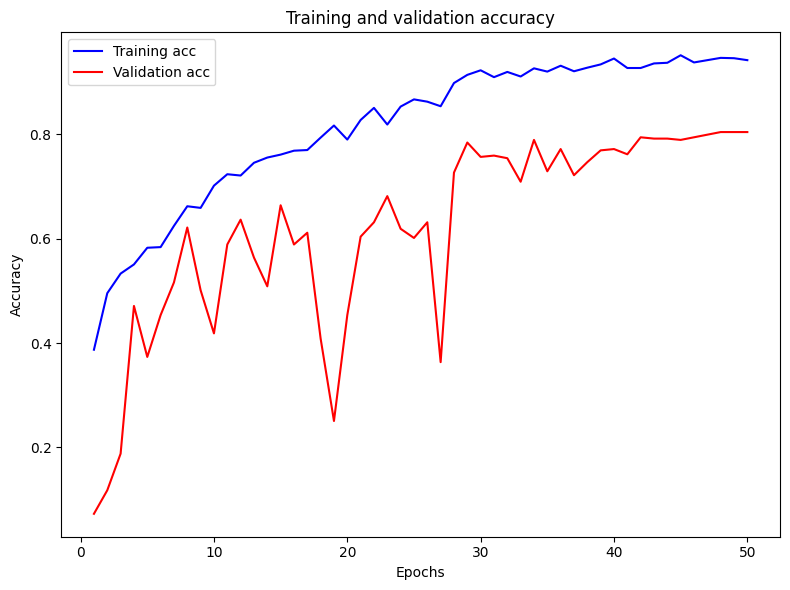

In [ ]:
#plot results
plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True
loss = cnn_imbalanced.history['loss']
epochs = range(1, len(loss) + 1)
acc = cnn_imbalanced.history['accuracy']
val_acc = cnn_imbalanced.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('| CNN Classifiction Report (Imbalanced) |\n')
print(classification_report(y_true_imbalanced,y_pred_cnn_imbalanced,labels=[0,1,2,3,4,5,6,7],target_names=labels,zero_division=0))

| CNN Classifiction Report (Imbalanced) |

              precision    recall  f1-score   support

         B_A       0.95      0.86      0.90        22
         B_F       0.94      0.94      0.94        48
         B_P       0.94      1.00      0.97        16
         B_T       0.87      0.90      0.88        29
         M_D       0.92      0.97      0.94       171
         M_L       0.89      0.75      0.81        32
         M_M       0.93      0.87      0.90        47
         M_P       0.94      0.88      0.91        34

    accuracy                           0.92       399
   macro avg       0.92      0.90      0.91       399
weighted avg       0.92      0.92      0.92       399



<Figure size 700x700 with 0 Axes>

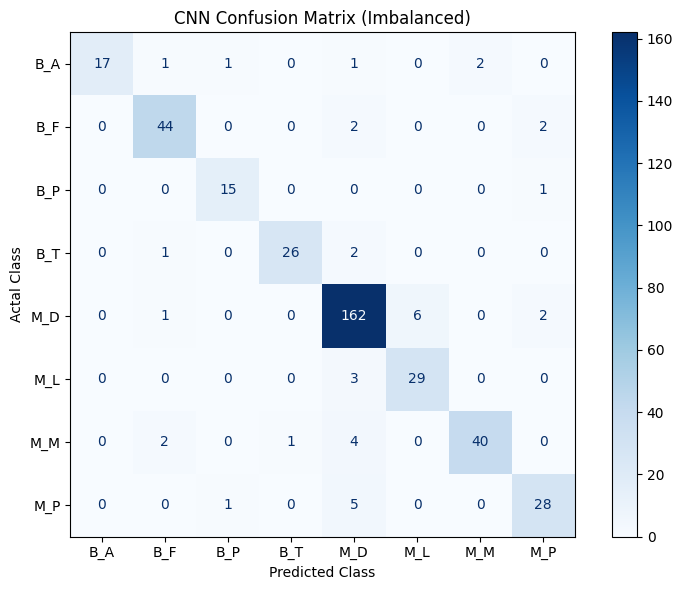

In [ ]:
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_true_imbalanced, y_pred_cnn_imbalanced,display_labels=labels,labels=[0,1,2,3,4,5,6,7],cmap='Blues')
plt.title('CNN Confusion Matrix (Imbalanced)')
plt.ylabel('Actal Class')
plt.xlabel('Predicted Class')
plt.show()

### Training CNN on Balanced Data

In [ ]:
#Fit model
cnn_balanced = cnn_model.fit(x_train_balanced,y_train_balanced, epochs=50,
                             validation_data = (x_test_balanced, y_test_balanced),
                             callbacks=callbacks_list
                            )

Epoch 1/50

172/172 [==============================] - 127s 729ms/step - loss: 0.1753 - accuracy: 0.9531 - val_loss: 0.9910 - val_accuracy: 0.7456 - lr: 0.0100

Epoch 2/50

172/172 [==============================] - 125s 728ms/step - loss: 0.1077 - accuracy: 0.9669 - val_loss: 1.2906 - val_accuracy: 0.7368 - lr: 0.0100

Epoch 3/50

172/172 [==============================] - 136s 791ms/step - loss: 0.0719 - accuracy: 0.9749 - val_loss: 1.9877 - val_accuracy: 0.6034 - lr: 0.0100

Epoch 4/50

172/172 [==============================] - 149s 871ms/step - loss: 0.0626 - accuracy: 0.9793 - val_loss: 0.5805 - val_accuracy: 0.8776 - lr: 0.0100

Epoch 5/50

172/172 [==============================] - 118s 686ms/step - loss: 0.0454 - accuracy: 0.9840 - val_loss: 0.3710 - val_accuracy: 0.9172 - lr: 0.0100

Epoch 6/50

172/172 [==============================] - 130s 759ms/step - loss: 0.0396 - accuracy: 0.9864 - val_loss: 0.8507 - val_accuracy: 0.8116 - lr: 0.0100

Epoch 7/50

172/172 [=============

In [ ]:
#Evaluate Model
train_loss_cnn_balanced, train_acc_cnn_balanced = cnn_model.evaluate(x_train_balanced,y_train_balanced)
test_loss_cnn_balanced, test_acc_cnn_balanced = cnn_model.evaluate(x_test_balanced, y_test_balanced)
print('-------------------------')
print('Train accuracy: {:5.2f}%'.format(100 * train_acc_cnn_balanced))
print('Test accuracy: {:5.2f}%'.format(100 * test_acc_cnn_balanced))

172/172 [==============================] - 7s 133ms/step - loss: 0.1407 - accuracy: 0.9856

43/43 [==============================] - 2s 130ms/step - loss: 0.4474 - accuracy: 0.9298

-------------------------

Train accuracy: 98.56%

Test accuracy: 92.98%


In [ ]:
y_pred_cnn_balanced = pd.DataFrame(np.round(cnn_model.predict(x_test_balanced))).idxmax(axis=1)
cnn_acc_balanced = accuracy_score(y_true_balanced,y_pred_cnn_balanced)
print('Accuracy of CNN on Balanced Data: {:5.2f}%'.format(100 * cnn_acc_balanced))

43/43 [==============================] - 0s 5ms/step
Accuracy of CNN on Balanced Data: 91.89%


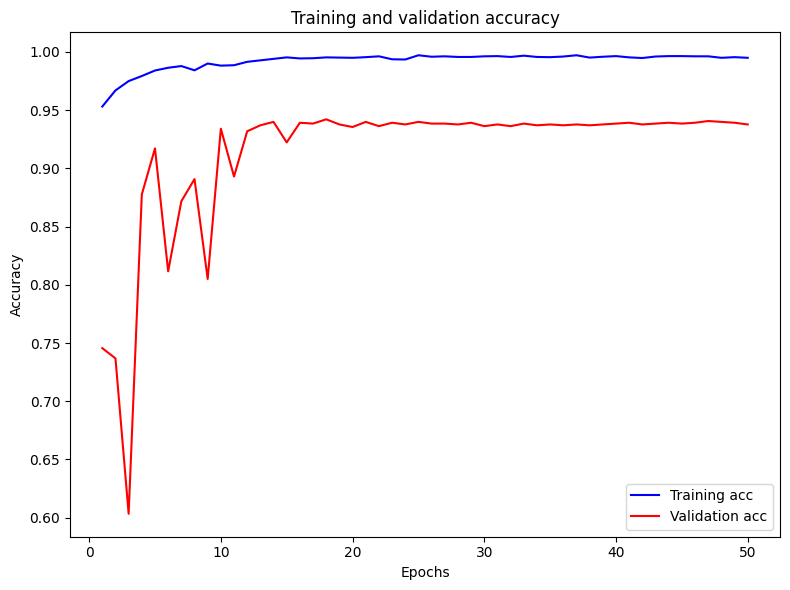

In [ ]:
#plot results
plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True
loss = cnn_balanced.history['loss']
epochs = range(1, len(loss) + 1)
acc = cnn_balanced.history['accuracy']
val_acc = cnn_balanced.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('| CNN Classifiction Report (Balanced) |\n')
print(classification_report(y_true_balanced,y_pred_cnn_balanced,labels=[0,1,2,3,4,5,6,7],target_names=labels,zero_division=0))

| CNN Classifiction Report (Balanced) |

              precision    recall  f1-score   support

         B_A       0.96      0.89      0.92       171
         B_F       0.95      0.94      0.94       171
         B_P       0.93      0.99      0.96       171
         B_T       0.94      0.93      0.94       171
         M_D       0.79      0.97      0.87       171
         M_L       0.92      0.89      0.90       171
         M_M       0.93      0.83      0.88       171
         M_P       0.97      0.91      0.94       171

    accuracy                           0.92      1368
   macro avg       0.92      0.92      0.92      1368
weighted avg       0.92      0.92      0.92      1368



<Figure size 700x700 with 0 Axes>

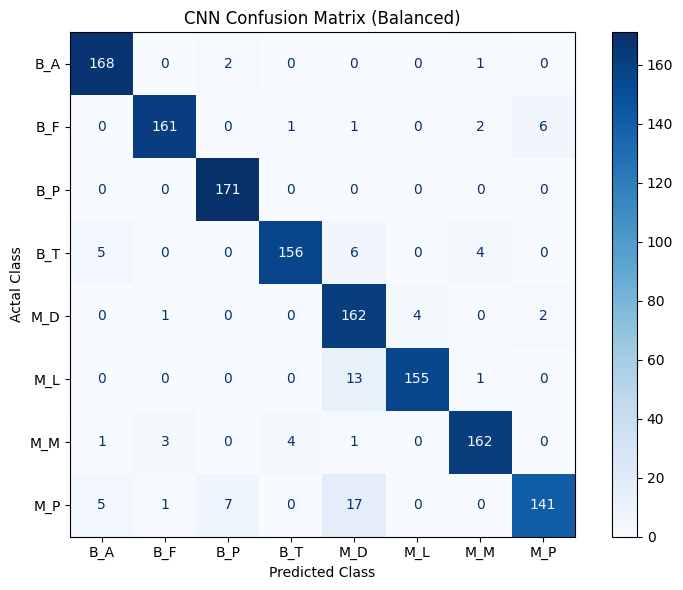

In [ ]:
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_true_balanced, y_pred_cnn_balanced,display_labels=labels,labels=[0,1,2,3,4,5,6,7],cmap='Blues')
plt.title('CNN Confusion Matrix (Balanced)')
plt.ylabel('Actal Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
cnn_model.save('/kaggle/working/models/cnn_balanced_model.h5')

## VGG19

### Defining VGG19

In [ ]:
vgg19 = VGG19(input_shape = (64,64,3), weights = 'imagenet', include_top = False)

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg19.layers:
    layer.trainable = False

x = Flatten()(vgg19.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(128, activation = 'relu',kernel_initializer='he_uniform')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(8, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

vgg19_model = Model(inputs = vgg19.input, outputs = x)
vgg19_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

### Compiling VGG19

In [ ]:
# Compile model
opt = RMSprop(learning_rate=0.1)
vgg19_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Add callbacks
#early_stop = EarlyStopping(monitor='val_loss', patience=10,verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',mode='max',patience = 5,factor=0.3, min_lr=0.00001)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,monitor= 'val_accuracy', mode= 'max',
                              save_weights_only=True,save_freq=5
                             )
callbacks_list = [cp_callback, learning_rate_reduction]

### Training VGG19 on Imbalanced Data

In [ ]:
vgg19_imbalanced = vgg19_model.fit(x_train_imbalanced,y_train_imbalanced,epochs=50,
                                   validation_data=(x_test_imbalanced,y_test_imbalanced),
                                   callbacks=callbacks_list
                                  )

Epoch 1/50
50/50 [==============================] - 5s 74ms/step - loss: 2.4478 - accuracy: 0.3609 - val_loss: 11.3476 - val_accuracy: 0.1203
Epoch 2/50
50/50 [==============================] - 8s 169ms/step - loss: 1.8938 - accuracy: 0.4110 - val_loss: 6.8542 - val_accuracy: 0.1278
Epoch 3/50
50/50 [==============================] - 7s 146ms/step - loss: 1.7631 - accuracy: 0.4492 - val_loss: 1.9483 - val_accuracy: 0.4511
Epoch 4/50
50/50 [==============================] - 4s 88ms/step - loss: 1.8187 - accuracy: 0.4492 - val_loss: 2.3109 - val_accuracy: 0.3609
Epoch 5/50
50/50 [==============================] - 6s 129ms/step - loss: 1.8305 - accuracy: 0.4392 - val_loss: 3.0482 - val_accuracy: 0.1729
Epoch 6/50
50/50 [==============================] - 5s 108ms/step - loss: 1.8767 - accuracy: 0.4518 - val_loss: 2.8417 - val_accuracy: 0.2331
Epoch 7/50
50/50 [==============================] - 4s 82ms/step - loss: 1.8130 - accuracy: 0.4662 - val_loss: 2.9743 - val_accuracy: 0.3158
Epoch 8/

In [ ]:
#Evaluate Model
train_loss_vgg_imbalanced, train_acc_vgg_imbalanced = vgg19_model.evaluate(x_train_imbalanced,y_train_imbalanced)
test_loss_vgg_imbalanced, test_acc_vgg_imbalanced = vgg19_model.evaluate(x_test_imbalanced, y_test_imbalanced)
print('-------------------------')
print('Train accuracy: {:5.2f}%'.format(100 * train_acc_vgg_imbalanced))
print('Test accuracy: {:5.2f}%'.format(100 * test_acc_vgg_imbalanced))

13/13 [==============================] - 0s 17ms/step - loss: 1.7317 - accuracy: 0.5514
-------------------------
Train accuracy: 84.96%
Test accuracy: 55.14%


In [ ]:
y_pred_vgg_imbalanced = pd.DataFrame(np.round(vgg19_model.predict(x_test_imbalanced))).idxmax(axis=1)
vgg_acc_imbalanced = accuracy_score(y_true_imbalanced,y_pred_vgg_imbalanced)
print('Accuracy of VGG-19 on Imbalanced Data: {:5.2f}%'.format(100 * vgg_acc_imbalanced))

13/13 [==============================] - 0s 20ms/step
Accuracy of VGG-19 on Imbalanced Data: 55.10%


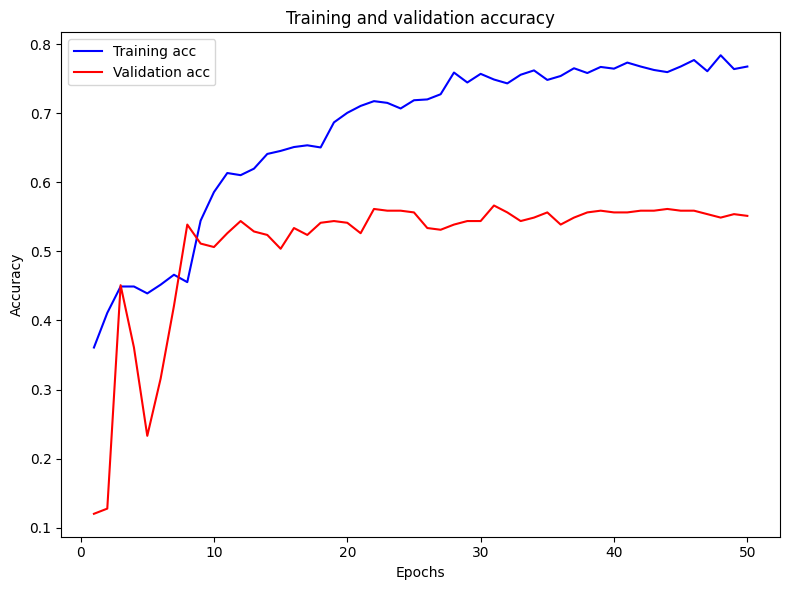

In [ ]:
#plot results
plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True
loss = vgg19_imbalanced.history['loss']
epochs = range(1, len(loss) + 1)
acc = vgg19_imbalanced.history['accuracy']
val_acc = vgg19_imbalanced.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('| VGG-19 Classifiction Report (Imbalanced) |\n')
print(classification_report(y_true_imbalanced,y_pred_vgg_imbalanced,labels=[0,1,2,3,4,5,6,7],target_names=labels,zero_division=0))

| VGG-19 Classifiction Report (Imbalanced) |

              precision    recall  f1-score   support

         B_A       0.15      0.50      0.24        22
         B_F       0.51      0.40      0.45        48
         B_P       0.33      0.31      0.32        16
         B_T       0.62      0.45      0.52        29
         M_D       0.65      0.73      0.69       171
         M_L       0.59      0.31      0.41        32
         M_M       0.45      0.19      0.27        47
         M_P       0.48      0.38      0.43        34

    accuracy                           0.51       399
   macro avg       0.47      0.41      0.41       399
weighted avg       0.55      0.51      0.51       399



<Figure size 700x700 with 0 Axes>

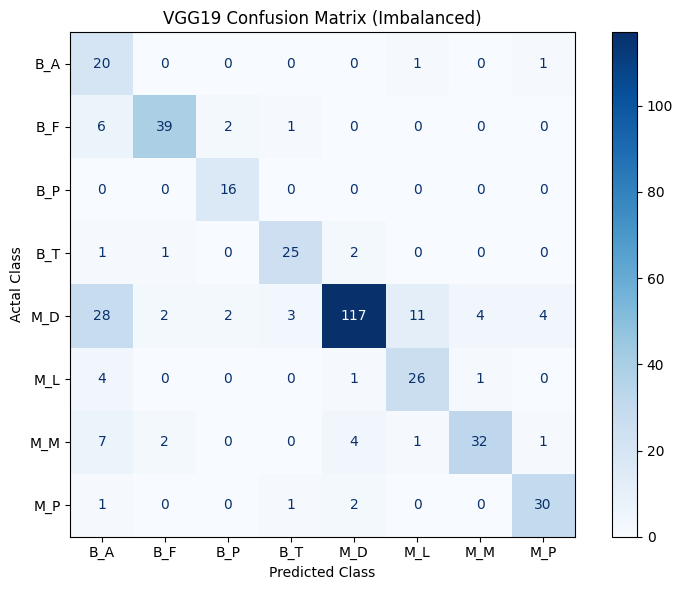

In [ ]:
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_true_imbalanced, y_pred_vgg_imbalanced,display_labels=labels,labels=[0,1,2,3,4,5,6,7],cmap='Blues')
plt.title('VGG19 Confusion Matrix (Imbalanced)')
plt.ylabel('Actal Class')
plt.xlabel('Predicted Class')
plt.show()

### Training VGG19 on Balanced Data

In [ ]:
vgg19_balanced = vgg19_model.fit(x_train_balanced,y_train_balanced, epochs=50,
                                 validation_data = (x_test_balanced, y_test_balanced),
                                 callbacks=callbacks_list
                                )

Epoch 1/50
172/172 [==============================] - 20s 110ms/step - loss: 2.4055 - accuracy: 0.2708 - val_loss: 2.9347 - val_accuracy: 0.2679
Epoch 2/50
172/172 [==============================] - 19s 112ms/step - loss: 2.0449 - accuracy: 0.3301 - val_loss: 3.7728 - val_accuracy: 0.2269
Epoch 3/50
172/172 [==============================] - 17s 101ms/step - loss: 1.9647 - accuracy: 0.3628 - val_loss: 2.2380 - val_accuracy: 0.3448
Epoch 4/50
172/172 [==============================] - 20s 116ms/step - loss: 1.8647 - accuracy: 0.4082 - val_loss: 2.2138 - val_accuracy: 0.3594
Epoch 5/50
172/172 [==============================] - 21s 122ms/step - loss: 1.8153 - accuracy: 0.4178 - val_loss: 2.1964 - val_accuracy: 0.3448
Epoch 6/50
172/172 [==============================] - 16s 92ms/step - loss: 1.7914 - accuracy: 0.4240 - val_loss: 2.0580 - val_accuracy: 0.3704
Epoch 7/50
172/172 [==============================] - 23s 133ms/step - loss: 1.7332 - accuracy: 0.4462 - val_loss: 2.6747 - val_acc

In [ ]:
#Evaluate Model
train_loss_vgg_balanced, train_acc_vgg_balanced = vgg19_model.evaluate(x_train_balanced, y_train_balanced)
test_loss_vgg_balanced, test_acc_vgg_balanced = vgg19_model.evaluate(x_test_balanced, y_test_balanced)
print('-------------------------')
print('Train accuracy: {:5.2f}%'.format(100 * train_acc_vgg_balanced))
print('Test accuracy: {:5.2f}%'.format(100 * test_acc_vgg_balanced))

43/43 [==============================] - 1s 12ms/step - loss: 2.1711 - accuracy: 0.7785
-------------------------
Train accuracy: 88.64%
Test accuracy: 77.85%


In [ ]:
y_pred_vgg_balanced = pd.DataFrame(np.round(vgg19_model.predict(x_test_balanced))).idxmax(axis=1)
vgg_acc_balanced = accuracy_score(y_true_balanced,y_pred_vgg_balanced)
print('Accuracy of VGG-19 on Balanced Data: {:5.2f}%'.format(100 * vgg_acc_balanced))

43/43 [==============================] - 0s 10ms/step
Accuracy of VGG-19 on Balanced Data: 77.55%


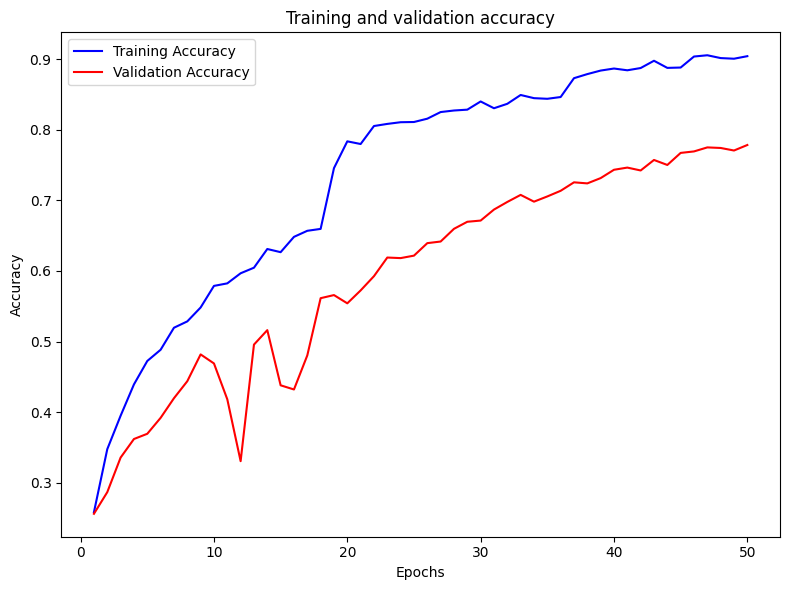

In [ ]:
#plot results
plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True
loss = vgg19_balanced.history['loss']
epochs = range(1, len(loss) + 1)
acc = vgg19_balanced.history['accuracy']
val_acc = vgg19_balanced.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('| VGG-19 Classifiction Report (Balanced) |\n')
print(classification_report(y_true_balanced,y_pred_vgg_balanced,labels=[0,1,2,3,4,5,6,7],target_names=labels,zero_division=0))

| VGG-19 Classifiction Report (Balanced) |

              precision    recall  f1-score   support

         B_A       0.48      0.83      0.61       171
         B_F       0.82      0.63      0.71       171
         B_P       0.86      0.91      0.88       171
         B_T       0.91      0.81      0.86       171
         M_D       0.77      0.68      0.72       171
         M_L       0.85      0.86      0.85       171
         M_M       0.94      0.70      0.80       171
         M_P       0.87      0.79      0.83       171

    accuracy                           0.78      1368
   macro avg       0.81      0.78      0.78      1368
weighted avg       0.81      0.78      0.78      1368



<Figure size 700x700 with 0 Axes>

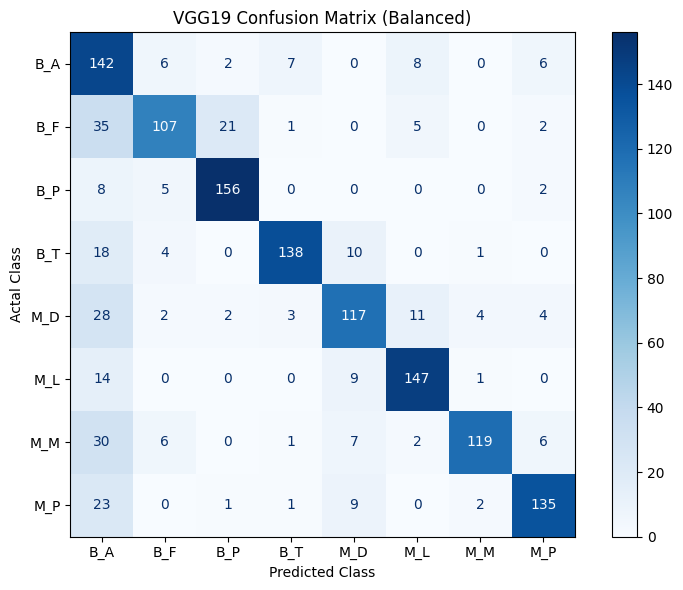

In [ ]:
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_true_balanced, y_pred_vgg_balanced,display_labels=labels,labels=[0,1,2,3,4,5,6,7],cmap='Blues')
plt.title('VGG19 Confusion Matrix (Balanced)')
plt.ylabel('Actal Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
vgg19_model.save('models/vgg19_balanced_model.h5')

## DenseNet121

### Defining DenseNet121

In [ ]:
densenet121 = DenseNet121(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in densenet121.layers:
    layer.trainable = False

# Add custom layers for classification
x = Flatten()(densenet121.output)
x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='softmax')(x)  # Output layer for 8 classes

# Create the final DenseNet-based model
densenet121_model = Model(inputs=densenet121.input, outputs=x)
densenet121_model.summary()

29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 32, 32, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

### Compiling DenseNet121

In [ ]:
# Compile the model
opt = Adam(learning_rate=0.1)
densenet121_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,save_freq=5,
                             )
callbacks_list = [cp_callback, learning_rate_reduction]

### Trainng DenseNet121 on Imbalanced Data

In [ ]:
densenet121_imbalanced = densenet121_model.fit(x_train_imbalanced,y_train_imbalanced, epochs=50,
                               validation_data = (x_test_imbalanced, y_test_imbalanced),
                               callbacks=callbacks_list
                              )

Epoch 1/50
50/50 [==============================] - 30s 300ms/step - loss: 2.5753 - accuracy: 0.2769 - val_loss: 2.3614 - val_accuracy: 0.3659 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 9s 193ms/step - loss: 1.8804 - accuracy: 0.4223 - val_loss: 1.5284 - val_accuracy: 0.5338 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 9s 190ms/step - loss: 1.5289 - accuracy: 0.4981 - val_loss: 1.4997 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 10s 194ms/step - loss: 1.3647 - accuracy: 0.5294 - val_loss: 1.1610 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 10s 195ms/step - loss: 1.3027 - accuracy: 0.5758 - val_loss: 1.1304 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 10s 195ms/step - loss: 1.1860 - accuracy: 0.6096 - val_loss: 1.1744 - val_accuracy: 0.6291 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 10s 197ms/step

In [ ]:
#Evaluate Model
train_loss_densenet_imbalanced, train_acc_densenet_imbalanced = densenet121_model.evaluate(x_train_imbalanced,y_train_imbalanced)
test_loss_densenet_imbalanced, test_acc_densenet_imbalanced = densenet121_model.evaluate(x_test_imbalanced, y_test_imbalanced)
print('-------------------------')
print('Train accuracy: {:5.2f}%'.format(100 * train_acc_densenet_imbalanced))
print('Test accuracy: {:5.2f}%'.format(100 * test_acc_densenet_imbalanced))

13/13 [==============================] - 0s 17ms/step - loss: 1.1917 - accuracy: 0.6341
-------------------------
Train accuracy: 98.25%
Test accuracy: 63.41%


In [ ]:
y_pred_densenet_imbalanced = pd.DataFrame(np.round(densenet121_model.predict(x_test_imbalanced))).idxmax(axis=1)
densenet_acc_imbalanced = accuracy_score(y_true_imbalanced,y_pred_densenet_imbalanced)
print('Accuracy of DenseNet-121 on Imbalanced Data: {:5.2f}%'.format(100 * densenet_acc_imbalanced))

13/13 [==============================] - 2s 20ms/step
Accuracy of DenseNet-121 on Imbalanced Data: 61.40%


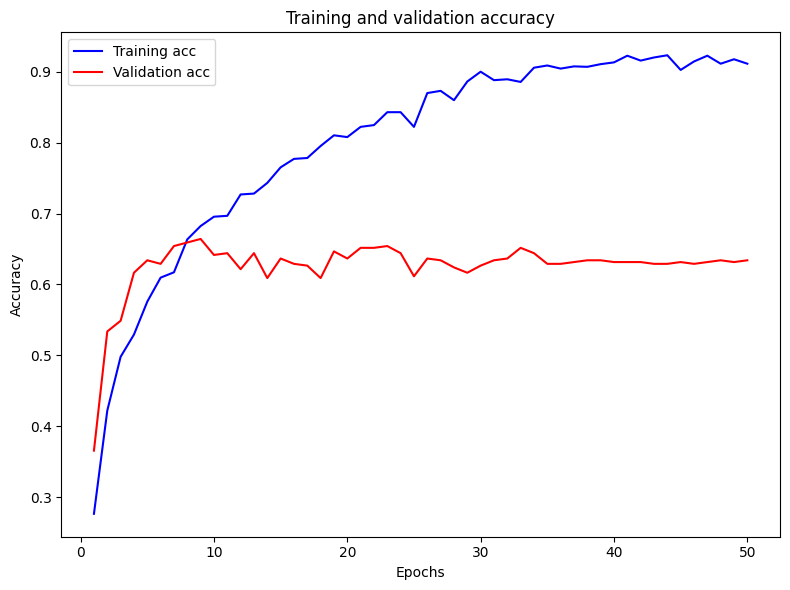

In [ ]:
#plot results
plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True
loss = densenet121_imbalanced.history['loss']
epochs = range(1, len(loss) + 1)
acc = densenet121_imbalanced.history['accuracy']
val_acc = densenet121_imbalanced.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('| DenseNet-121 Classifiction Report (Imbalanced) |\n')
print(classification_report(y_true_imbalanced,y_pred_densenet_imbalanced,labels=[0,1,2,3,4,5,6,7],target_names=labels,zero_division=0))

| DenseNet-121 Classifiction Report (Imbalanced) |

              precision    recall  f1-score   support

         B_A       0.26      0.64      0.37        22
         B_F       0.51      0.52      0.52        48
         B_P       0.50      0.38      0.43        16
         B_T       0.73      0.66      0.69        29
         M_D       0.75      0.80      0.77       171
         M_L       0.50      0.31      0.38        32
         M_M       0.71      0.47      0.56        47
         M_P       0.50      0.38      0.43        34

    accuracy                           0.61       399
   macro avg       0.56      0.52      0.52       399
weighted avg       0.64      0.61      0.62       399



<Figure size 700x700 with 0 Axes>

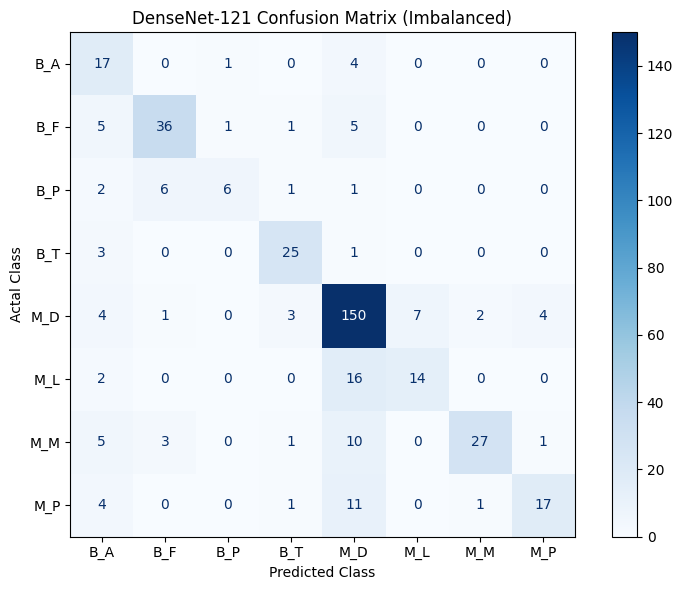

In [ ]:
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_true_imbalanced, y_pred_densenet_imbalanced,display_labels=labels,labels=[0,1,2,3,4,5,6,7],cmap='Blues')
plt.title('DenseNet-121 Confusion Matrix (Imbalanced)')
plt.ylabel('Actal Class')
plt.xlabel('Predicted Class')
plt.show()

### Training DenseNet121 on Balanced Data

In [ ]:
densenet121_balanced = densenet121_model.fit(x_train_balanced,y_train_balanced, epochs=50,
                               validation_data = (x_test_balanced, y_test_balanced),
                               callbacks=callbacks_list
                              )

Epoch 1/50
174/174 [==============================] - 42s 199ms/step - loss: 2.7760 - accuracy: 0.2581 - val_loss: 4.6885 - val_accuracy: 0.2558 - lr: 0.1000
Epoch 2/50
174/174 [==============================] - 34s 191ms/step - loss: 2.1425 - accuracy: 0.3474 - val_loss: 2.5299 - val_accuracy: 0.4247 - lr: 0.1000
Epoch 3/50
174/174 [==============================] - 33s 190ms/step - loss: 2.0389 - accuracy: 0.3948 - val_loss: 2.2360 - val_accuracy: 0.3618 - lr: 0.1000
Epoch 4/50
174/174 [==============================] - 33s 189ms/step - loss: 1.9952 - accuracy: 0.4392 - val_loss: 3.6301 - val_accuracy: 0.2865 - lr: 0.1000
Epoch 5/50
174/174 [==============================] - 33s 189ms/step - loss: 1.9110 - accuracy: 0.4724 - val_loss: 2.3397 - val_accuracy: 0.4196 - lr: 0.1000
Epoch 6/50
174/174 [==============================] - 33s 189ms/step - loss: 1.8833 - accuracy: 0.4883 - val_loss: 4.6826 - val_accuracy: 0.3355 - lr: 0.1000
Epoch 7/50
174/174 [==============================] 

In [ ]:
#Evaluate Model
train_loss_densenet_balanced, train_acc_densenet_balanced = densenet121_model.evaluate(x_train_balanced,y_train_balanced)
test_loss_densenet_balanced, test_acc_densenet_balanced = densenet121_model.evaluate(x_test_balanced, y_test_balanced)
print('-------------------------')
print('Train accuracy: {:5.2f}%'.format(100 * train_acc_densenet_balanced))
print('Test accuracy: {:5.2f}%'.format(100 * test_acc_densenet_balanced))

43/43 [==============================] - 1s 15ms/step - loss: 1.6613 - accuracy: 0.73.68
-------------------------
Train accuracy: 98.12%
Test accuracy: 73.68%


In [ ]:
y_pred_densenet_balanced = pd.DataFrame(np.round(densenet121_model.predict(x_test_balanced))).idxmax(axis=1)
densenet_acc_balanced = accuracy_score(y_true_balanced,y_pred_densenet_balanced)
print('Accuracy of DenseNet-121 on Balanced Data: {:5.2f}%'.format(100 * densenet_acc_balanced))

43/43 [==============================] - 3s 15ms/step
Accuracy of DenseNet-121 on Balanced Data: 73.18%


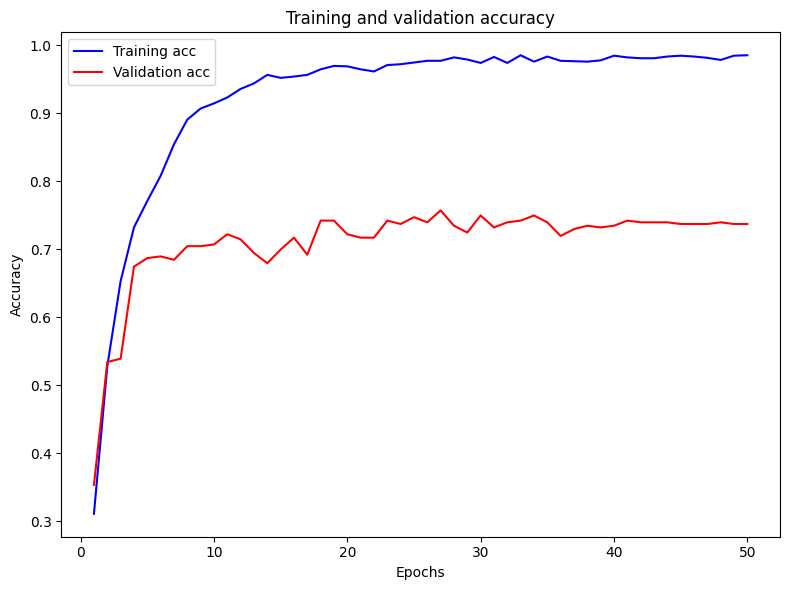

In [ ]:
#plot results
plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True
loss = densenet121_balanced.history['loss']
epochs = range(1, len(loss) + 1)
acc = densenet121_balanced.history['accuracy']
val_acc = densenet121_balanced.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('| DenseNet-121 Classifiction Report (Balanced) |\n')
print(classification_report(y_true_balanced,y_pred_densenet_balanced,labels=[0,1,2,3,4,5,6,7],target_names=labels,zero_division=0))

| DenseNet-121 Classifiction Report (Balanced) |

              precision    recall  f1-score   support

         B_A       0.40      0.77      0.53        22
         B_F       0.78      0.75      0.77        48
         B_P       0.75      0.38      0.50        16
         B_T       0.78      0.86      0.82        29
         M_D       0.76      0.88      0.81       171
         M_L       0.67      0.44      0.53        32
         M_M       0.90      0.57      0.70        47
         M_P       0.77      0.50      0.61        34

    accuracy                           0.73       399
   macro avg       0.73      0.64      0.66       399
weighted avg       0.75      0.73      0.73       399


<Figure size 700x700 with 0 Axes>

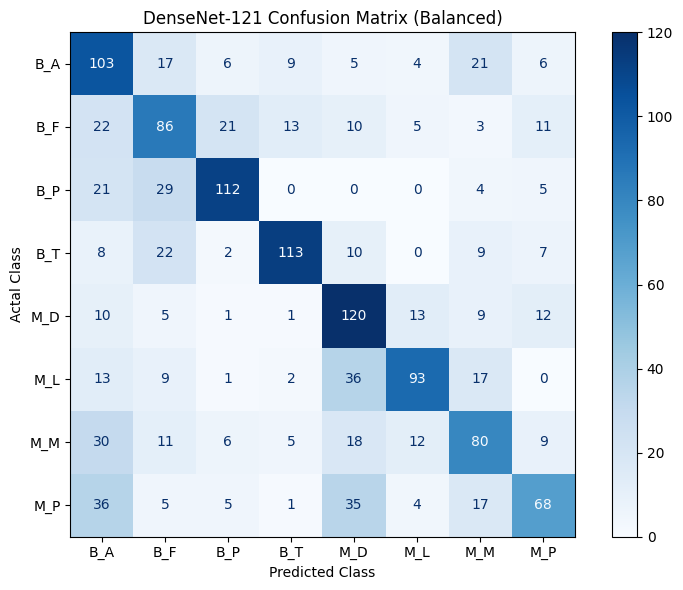

In [ ]:
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_true_balanced, y_pred_densenet_balanced,display_labels=labels,labels=[0,1,2,3,4,5,6,7],cmap='Blues')
plt.title('DenseNet-121 Confusion Matrix (Balanced)')
plt.ylabel('Actal Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
densenet121_model.save('models/densenet121_balanced_model.h5')

## Ensemble Model

In [ ]:
cnn_model_load = load_model('/kaggle/input/loadmodels/cnn_balanced_model.h5')
vgg19_model_load = load_model('/kaggle/input/loadmodels/vgg19_balanced_model.h5')
densenet121_model_load = load_model('/kaggle/input/loadmodels/densenet121_balanced_model.h5')

models = [cnn_model_load, vgg19_model_load, densenet121_model_load]

preds = [model.predict(x_test_balanced) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)
ensemble_prediction = np.argmax(summed, axis=1)

#cnn_prediction = cnn_model.predict(test_img_balanced)
#vgg19_prediction = vgg19_model.predict(test_img_balanced)
#resnet50_prediction = resnet50_model.predict(test_img_balanced)
weights = [0.6, 0.2, 0.2]
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

y_pred_cnn = pd.DataFrame(np.round(cnn_model_load.predict(x_test_balanced))).idxmax(axis=1)
y_pred_vgg = pd.DataFrame(np.round(vgg19_model_load.predict(x_test_balanced))).idxmax(axis=1)
y_pred_densenet = pd.DataFrame(np.round(densenet121_model_load.predict(x_test_balanced))).idxmax(axis=1)


cnn_accuracy = accuracy_score(y_true_balanced, y_pred_cnn)
vgg19_accuracy = accuracy_score(y_true_balanced, y_pred_vgg)
densenet121_accuracy = accuracy_score(y_true_balanced, y_pred_densenet)
ensemble_accuracy = accuracy_score(y_true_balanced, ensemble_prediction)
weighted_accuracy = accuracy_score(y_true_balanced, weighted_ensemble_prediction)

print('Accuracy Score for CNN = {:.2%}'.format(cnn_accuracy))
print('Accuracy Score for VGG19 = {:.2%}'.format(vgg19_accuracy))
print('Accuracy Score for DenseNet121 = {:.2%}'.format(densenet121_accuracy))
print('Accuracy Score for Average Ensemble  = {:.2%}'.format(ensemble_accuracy))
print('Accuracy Score for Weighted Average Ensemble = {:.2%}'.format(weighted_accuracy))

43/43 [==============================] - 1s 12ms/step
Accuracy Score for CNN = 91.89%
Accuracy Score for VGG19 = 77.56%
Accuracy Score for DenseNet121 = 73.18%
Accuracy Score for Average Ensemble  = 92.91%
Accuracy Score for Weighted Average Ensemble = 93.20%


1/1 [==============================] - 0s 29ms/step
Original class is: B_P
Predicted class is: B_P


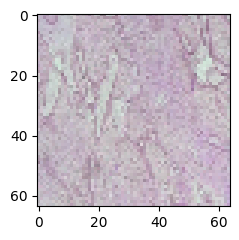

In [ ]:
test_img_number = random.randint(0, len(x_test_balanced)-1)
test_img = x_test_balanced[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth= np.argmax(y_test_balanced[test_img_number], axis=None)
#prediction = cnn_model.predict(test_img_input)
#print(prediction)
prediction = [model.predict(test_img_input) for model in models]
prediction=np.array(prediction)
#summed_pred = np.sum(prediction, axis=0)
#predicted_class = np.argmax(summed_pred, axis=None)

weights = [0.6, 0.2, 0.2]
weighted_prediction = np.tensordot(prediction, weights, axes=((0),(0)))
predicted_class = np.argmax(weighted_prediction, axis=None)

#predicted_class = np.argmax(prediction, axis=None)

plt.figure(figsize=(2.5, 2.5))
plt.imshow(test_img)

original_label=labels[ground_truth]
prediction_label=labels[predicted_class]

print("Original class is:", original_label)
print("Predicted class is:", prediction_label)